In [133]:
from PIL import Image
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import os
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [134]:
CLASS_REAL = 0
CLASS_FAKE = 1

In [135]:
def accuracy(conf_mat):
    return (conf_mat[0, 0] + conf_mat[1, 1]) / np.sum(conf_mat)

def precision(conf_mat):
    return conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[1, 0])

def recall(conf_mat):
    return conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])

def specificity(conf_mat):
    return conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])

def fmeasure(conf_mat):
    p = precision(conf_mat)
    r = recall(conf_mat)
    return 2 * p * r / (p + r)

In [136]:
@jit
def load_dataset(path = './dataset/'):

    imgs = []

    for img in os.listdir(path + 'real/'):
        imgs.append(
            np.array(Image.open(path + 'real/' + img).convert('L').resize((100, 100)))
        )

        if len(imgs) == 500:
            break

    for img in os.listdir(path + 'spoof/'):
        imgs.append(
            np.array(Image.open(path + 'spoof/' + img).convert('L').resize((100, 100)))
        )

        if len(imgs) == 1000:
            break

    return imgs, [CLASS_REAL] * 500 + [CLASS_FAKE] * 500

C:\Users\adhtr\AppData\Local\Temp\ipykernel_20356\2793397743.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def load_dataset(path = './dataset/'):


In [137]:
X, y = load_dataset();

C:\Users\adhtr\AppData\Local\Temp\ipykernel_20356\2793397743.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "load_dataset" failed type inference due to: Unknown attribute 'listdir' of type Module(<module 'os' from 'c:\\Users\\adhtr\\scoop\\apps\\python39\\current\\lib\\os.py'>)

File "..\..\..\AppData\Local\Temp\ipykernel_20356\2793397743.py", line 6:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\adhtr\AppData\Local\Temp\ipykernel_20356\2793397743.py (6)

File "..\..\..\AppData\Local\Temp\ipykernel_20356\2793397743.py", line 6:
<source missing, REPL/exec in use?>

  @jit
C:\Users\adhtr\AppData\Local\Temp\ipykernel_20356\2793397743.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "load_dataset" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\AppData\Local\Temp\ipyk

In [138]:
X_train = X[:400] + X[500:900]
y_train = y[:400] + y[500:900]
X_test = X[400:500] + X[900:1000]
y_test = y[400:500] + y[900:1000]

Using the raw pixel values of the face images as features. Train a Support Vector Machine (SVM) classifier on these raw pixel features to perform face recognition. Evaluate and analyze the performance of the model on the dataset.

In [139]:
def flatten_imgs(imgs):
    return [img.flatten() / 255 for img in imgs]

### RAW

In [140]:
X_train_raw_flatten = flatten_imgs(X_train)

In [141]:
svc_raw = SVC(kernel = 'linear', max_iter=5000, random_state=22016)

svc_raw.fit(X_train_raw_flatten, y_train)

c:\Users\adhtr\scoop\apps\python39\current\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=5000, random_state=22016)

In [142]:
y_hat_raw = svc_raw.predict(flatten_imgs(X_test))

In [143]:
cm = confusion_matrix(y_test, y_hat_raw)

print('Accuracy:', accuracy(cm))
print('Precision', precision(cm))
print('Recall', recall(cm))
print('Confusion Matrix:\n', cm)

Accuracy: 0.51
Precision 0.5102040816326531
Recall 0.5
Confusion Matrix:
 [[50 50]
 [48 52]]


### LBP

In [144]:
@jit(nopython=True)
def lbp(images: list[np.ndarray]):
    lbps = []

    for image in images:
        rows, cols = image.shape
        
        # Create an empty array to store LBP image
        lbp_image = np.zeros((rows, cols), dtype=np.uint8)
        
        # Loop through each pixel (excluding the border pixels)
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                center = image[i, j]
                lbp_value = 0
                
                # Manually compute the LBP using bit shifts
                lbp_value |= (image[i-1, j-1] > center) << 7  # top-left
                lbp_value |= (image[i-1, j] > center) << 6    # top
                lbp_value |= (image[i-1, j+1] > center) << 5  # top-right
                lbp_value |= (image[i, j+1] > center) << 4    # right
                lbp_value |= (image[i+1, j+1] > center) << 3  # bottom-right
                lbp_value |= (image[i+1, j] > center) << 2    # bottom
                lbp_value |= (image[i+1, j-1] > center) << 1  # bottom-left
                lbp_value |= (image[i, j-1] > center) << 0    # left
                
                lbp_image[i, j] = lbp_value

        lbps.append(lbp_image)

    return lbps

In [145]:
X_train_lbp = lbp(X_train)

c:\Users\adhtr\scoop\apps\python39\current\lib\site-packages\numba\core\ir_utils.py:2174: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'images' of function 'lbp'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Temp\ipykernel_20356\1079731044.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


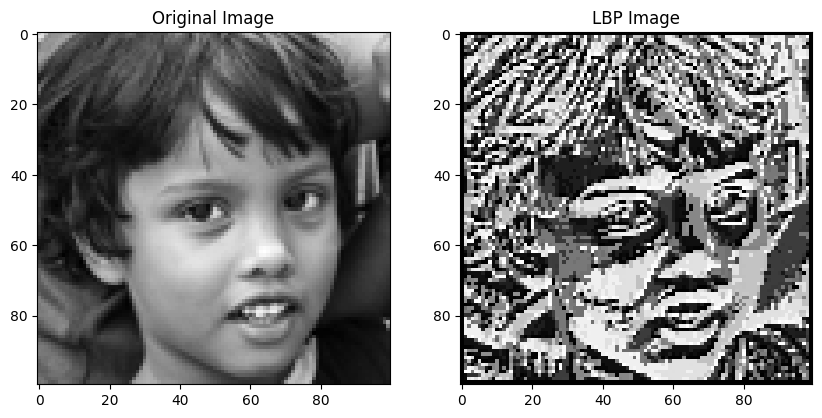

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train[0], cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(X_train_lbp[0], cmap='gray')
axs[1].set_title('LBP Image')

plt.show();

In [147]:
X_train_lbp_flatten = flatten_imgs(X_train_lbp)

svc_lbp = SVC(kernel = 'linear', max_iter=10000, random_state=22016)

svc_lbp.fit(X_train_lbp_flatten, y_train)

SVC(kernel='linear', max_iter=10000, random_state=22016)

In [148]:
X_test_lbp = lbp(X_test)

y_hat_lbp = svc_raw.predict(flatten_imgs(X_test_lbp))

In [149]:
cm = confusion_matrix(y_test, y_hat_lbp)

print('Accuracy:', accuracy(cm))
print('Precision', precision(cm))
print('Recall', recall(cm))
print('Confusion Matrix:\n', cm)

Accuracy: 0.445
Precision 0.43956043956043955
Recall 0.4
Confusion Matrix:
 [[40 60]
 [51 49]]


### Edge as feature vector

In [150]:
@jit(nopython=True)
def _filter2d(image : np.ndarray, filter : np.ndarray, padding : int) -> np.ndarray:
    '''
    This function uses JIT compilation supported functions only to give
    huge boost in performance. We are talking about around 10x speedup here.
    '''

    filtered_image = np.zeros(
        (image.shape[0] - 2 * padding, image.shape[1] - 2 * padding), dtype=np.float64
    )

    for i in range(padding, image.shape[0] - padding):
        for j in range(padding, image.shape[1] - padding):
            img_chunk = image[i-padding:i+padding+1, j-padding:j+padding+1]
            filtered_image[i - padding, j - padding] = np.sum(filter * img_chunk)

    return filtered_image


def filter2d(images : list[np.ndarray], filter : np.ndarray) -> np.ndarray:
    '''
    This function applies a 2D square filter with odd dimensions to an image.
    '''

    if filter.shape[0] != filter.shape[1]:
        raise ValueError("Filter must be square")
    if filter.shape[0] % 2 == 0:
        raise ValueError("Filter must have odd dimensions")

    filtered_images = []

    for image in images:
        padding = filter.shape[0] // 2
        padded_image = np.pad(image, (padding, padding), mode = 'edge', )

        filtered_images.append(_filter2d(padded_image, filter, padding))

    return filtered_images

#### Prewitt

In [151]:
prewitt_dx = np.array((
    (-1, 0, 1),
    (-1, 0, 1),
    (-1, 0, 1)
)) / 3.

prewitt_dy = prewitt_dx.T

Text(0.5, 1.0, 'Prewitt Gradient')

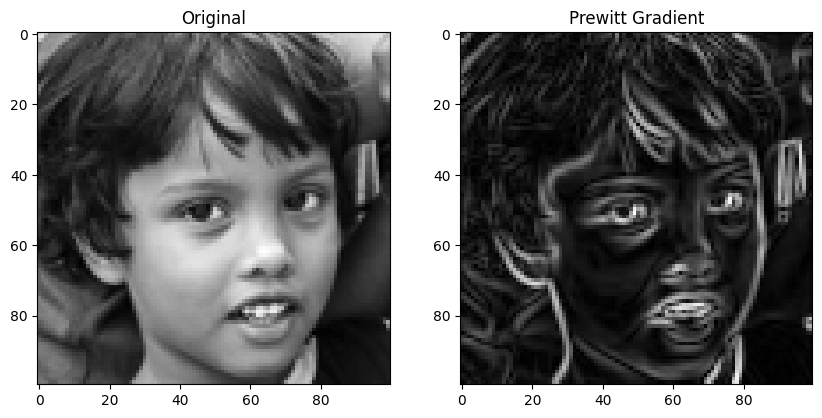

In [152]:
X_train_prewitt_dx = filter2d(X_train, prewitt_dx)
X_train_prewitt_dy = filter2d(X_train, prewitt_dy)

X_train_prewitt = [np.sqrt(dx**2 + dy**2) for dx, dy in zip(X_train_prewitt_dx, X_train_prewitt_dy)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train[0], cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(X_train_prewitt[0], cmap='gray')
axs[1].set_title('Prewitt Gradient')

In [153]:
X_train_prewitt_flatten = flatten_imgs(X_train_prewitt)

svc_prewitt = SVC(kernel = 'linear', max_iter=10000, random_state=22016)

svc_prewitt.fit(X_train_prewitt_flatten, y_train)

SVC(kernel='linear', max_iter=10000, random_state=22016)

In [154]:
X_test_prewitt_dx = filter2d(X_test, prewitt_dx)
X_test_prewitt_dy = filter2d(X_test, prewitt_dy)

X_test_prewitt = [np.sqrt(dx**2 + dy**2) for dx, dy in zip(X_test_prewitt_dx, X_test_prewitt_dy)]

y_hat_prewitt = svc_prewitt.predict(flatten_imgs(X_test_prewitt))

cm = confusion_matrix(y_test, y_hat_prewitt)

print('Accuracy:', (cm[0, 0] + cm[1, 1]) / 200)
print('Precision', precision(cm))
print('Recall', recall(cm))
print('Confusion Matrix:\n', cm)

Accuracy: 0.515
Precision 0.5132743362831859
Recall 0.58
Confusion Matrix:
 [[58 42]
 [55 45]]


#### Sobel

In [155]:
sobel_dx = np.array((
    (-1, 0, 1),
    (-2, 0, 2),
    (-1, 0, 1)
)) / 3.

sobel_dy = sobel_dx.T

Text(0.5, 1.0, 'Sobel Gradient')

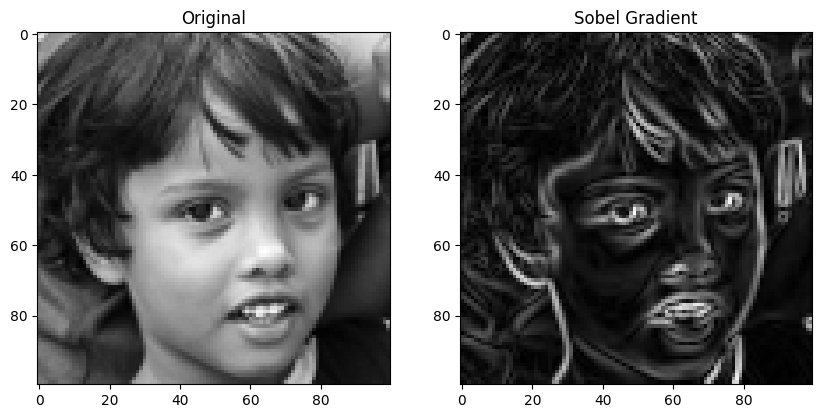

In [156]:
X_train_sobel_dx = filter2d(X_train, sobel_dx)
X_train_sobel_dy = filter2d(X_train, sobel_dy)

X_train_sobel = [np.sqrt(dx**2 + dy**2) for dx, dy in zip(X_train_sobel_dx, X_train_sobel_dy)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train[0], cmap='gray')
axs[0].set_title('Original')

axs[1].imshow(X_train_sobel[0], cmap='gray')
axs[1].set_title('Sobel Gradient')

In [157]:
X_train_sobel_flatten = flatten_imgs(X_train_sobel)

svc_sobel = SVC(kernel = 'linear', max_iter=10000, random_state=22016)

svc_sobel.fit(X_train_sobel_flatten, y_train)

SVC(kernel='linear', max_iter=10000, random_state=22016)

In [158]:
X_test_sobel_dx = filter2d(X_test, sobel_dx)
X_test_sobel_dy = filter2d(X_test, sobel_dy)

X_test_sobel = [np.sqrt(dx**2 + dy**2) for dx, dy in zip(X_test_sobel_dx, X_test_sobel_dy)]

y_hat_sobel = svc_sobel.predict(flatten_imgs(X_test_sobel))

cm = confusion_matrix(y_test, y_hat_sobel)

print('Accuracy:', (cm[0, 0] + cm[1, 1]) / 200)
print('Precision', precision(cm))
print('Recall', recall(cm))
print('Confusion Matrix:\n', cm)

Accuracy: 0.52
Precision 0.5175438596491229
Recall 0.59
Confusion Matrix:
 [[59 41]
 [55 45]]
